# Decision Tree


Сначала мы подготовим набор данных и обсудим наиболее важные функции. Затем мы найдем наилучшую глубину дерева, чтобы избежать переобучения, сгенерируем окончательную модель и объясним, как визуализировать полученное дерево.

## Подготовка данных

Для набора данных «Титаник» нам нужно угадать, выжили люди из набора тестовых данных или нет. Но для нашей текущей цели давайте также выясним, что могут рассказать нам данные о кораблекрушении с помощью дерева классификации. Давайте загрузим данные.

In [ ]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
ans = pd.read_csv('/content/ans.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
original_train = train.copy()
full_data = [train, test]

Для дальнейшего анализа преобразуем наши количественные данные в категориальные.

In [ ]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

Создадим переменные FamilySize и IsAlone. Обоснованность их включения изучалась на практике по визуализации.

In [ ]:
# FamilySize
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# IsAlone
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

Заполняем пропуски в данных.

In [ ]:
# Embarked
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Fare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Age
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)


## Какие **дополнительные** данные мы можем узнать из датасета?

In [ ]:
# Создадим переменную Title - статус человека из его колонки имени
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Сгруппируем
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

## Категориальные переменные

In [ ]:
for dataset in full_data:

    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [ ]:
# Удаляем ненужное
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


## Корреляции
Наш набор данных теперь стал намного чище, чем раньше, и содержит только числовые значения и потенциально значимые функции. Теперь исследуем взаимосвязь между нашими переменными, построив корреляции Пирсона между всеми атрибутами в нашем наборе данных:

<Axes: title={'center': 'Pearson Correlation of Features'}>

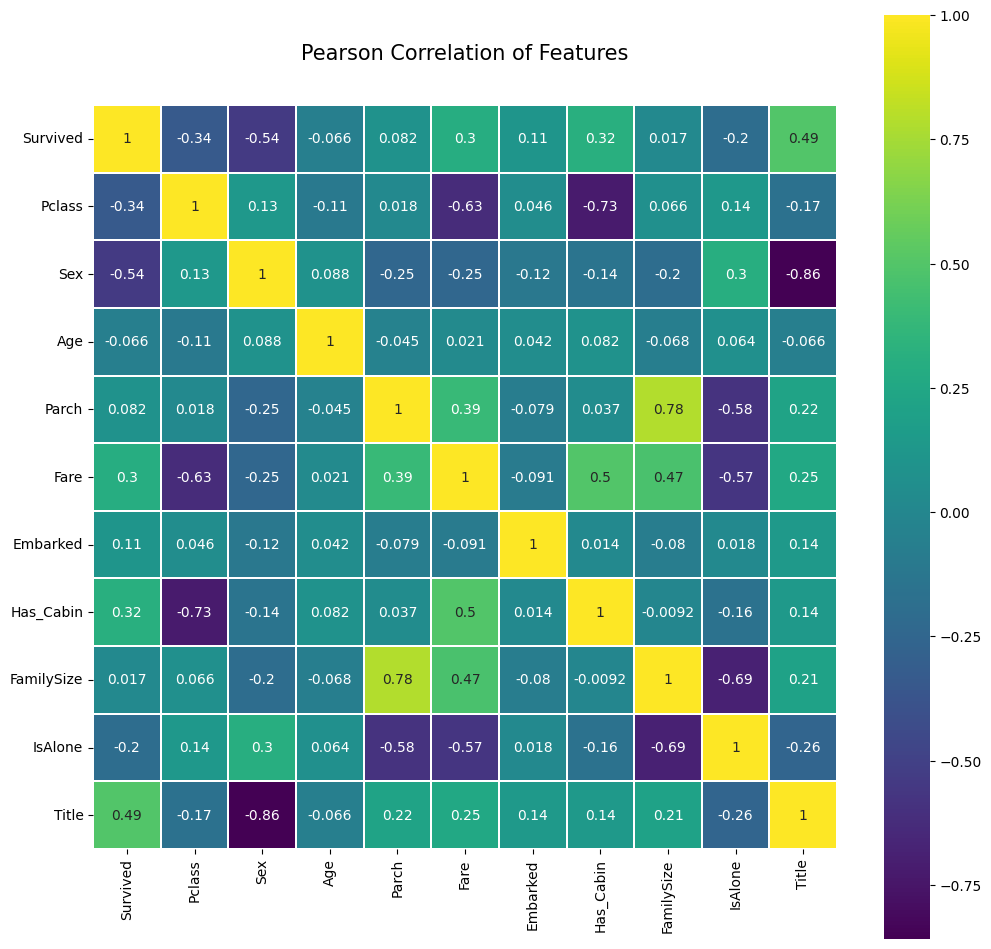

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Эта тепловая карта очень полезна в качестве предварительного анализа, поскольку вы можете легко получить представление о прогнозирующей ценности каждого признака. При этом Sex и Titul показывают самые высокие корреляции (в абсолютном выражении) с классом (Survived): 0,54 и 0,49 соответственно. Но абсолютная корреляция между ними также очень высока (0,86, самый высокий показатель в нашем наборе данных), поэтому они, вероятно, несут одну и ту же информацию, и использовать их в качестве входных данных для одной и той же модели было бы не очень хорошей идеей. Высока вероятность, что один из них будет использоваться для первого узла в нашем окончательном дереве решений, поэтому давайте сначала поймем кого оставить важнее.

# Проблема мультиколлинеарности


В машинном обучении (Machine Learning) мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.

Посмотрим разбиение для каждой переменной.

In [ ]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [ ]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# sex_mapping = {{'female': 0, 'male': 1}}

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

Данные показывают, что выжило меньше «мистеров» (15,67%), чем мужчин в целом (18,89%): таким образом, для нашей цели Titul кажется более полезным, чем Sex. Чтобы убедиться в этом, мы можем использовать копию исходных обучающих данных: проверить распределение пола, сгруппированное по титулу.

In [ ]:
title_and_sex = original_train.copy()[['Name', 'Sex']]

title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

Мы обнаружили, что, за исключением одного наблюдения (женщины с титулом «Dr»), все наблюдения для данного Titul имеют один и тот же пол. Таким образом, Titul фиксирует всю информацию, представленную в Sex. Кроме того, Titul может быть более ценным для нашей задачи, поскольку он отражает другие характеристики людей, такие как возраст, социальный класс, личность и т.д.


Весьма вероятно, что Title будет первым элементом в нашем окончательном дереве решений, что сделает переменную пола бесполезной после этого первоначального разделения.

## Gini Impurity - неопределенность Джини

Базовая идея дерева решений заключается в формировании запросов, с которыми алгоритм обращается к данным. При использовании алгоритма вопросы (также называемые разделением узлов) определяются таким образом, чтобы ответы вели к уменьшению неопределенности Джини (Gini Impurity). Это означает, что дерево решений формирует узлы, содержащие большое количество образцов (из набора исходных данных), принадлежащих к одному классу. Алгоритм старается обнаружить параметры со сходными значениями.

Коэффициент Джини - метрика, характеризующая эффективность модели.

Целью *деревьев* всегда является поиск наилучшего разделения для каждого узла дерева. Но измерение «качественности» данного разделения — это субъективный вопрос, поэтому на практике для оценки разделения используются разные показатели. Одним из часто используемых показателей является прирост информации. Библиотека sklearn, которую мы используем, реализует Gini Impurity, еще одну распространенную меру.

По сути этот коэффициент измеряет беспорядок набора элементов. Он рассчитывается как вероятность неправильной маркировки элемента при условии, что элемент помечен случайным образом в соответствии с распределением всех классов в наборе. Деревья решений попытаются найти разделение, которое наиболее снижает неопределенность Джини в двух результирующих узлах.

Для примера с «Титаником» его можно вычислить следующим образом (код должен быть достаточно явным):

In [ ]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Теперь мы собираемся смоделировать оба разбиения, вычислить неопределенность полученных узлов, а затем получить взвешенную неопределнность Джини после разделения, чтобы измерить, насколько каждое разделение фактически уменьшило непоределенность.

Если мы разделим по полу, у нас будут два следующих узла:

*   Узел с мужчинами: 577 наблюдений, выжило только 109.
*   Узел с женщинами: 314 наблюдений, из них 233 выжили.



In [ ]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [ ]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [ ]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [ ]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [ ]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [ ]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [ ]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

Мы обнаружили, что Titul немного лучше снижает Джини, чем Sex. Это подтверждает наш предыдущий анализ, и теперь мы уверены, что Title будет использоваться для первого разделения.

Таким образом, пол будет игнорироваться, поскольку информация уже включена в статус.

## Поиск лучшей глубины дерева с помощью перекрестной проверки


Изучив данные, мы обнаружим, что большая часть из них может иметь отношение к нашему дереву решений. Это критический момент для каждого проекта, поскольку слишком много обучающих данных может легко привести к плохому обобщению модели (точность тестовых/реальных/невидимых наблюдений).

Распространенной причиной является переобучение (модель, чрезмерно адаптированная к тренировочным данным).

В случае деревьев решений параметр **max_depth** определяет максимальное количество атрибутов, которые модель будет использовать для каждого прогноза (вплоть до количества доступных функций в наборе данных). Хороший способ найти наилучшее значение для этого параметра — просто перебрать все возможные глубины и измерить точность с помощью надежного метода, такого как перекрестная проверка.

**Перекрестная проверка** — это метод проверки модели, который разбивает набор обучающих данных на заданное количество «разбиений». Каждое разбиение использует разные данные для обучения и тестирования, что позволяет каждый раз обучать и тестировать модель с использованием разных данных. Это позволяет обучать и тестировать алгоритм со всеми доступными данными, избегая каких-либо ошибок разделения и давая хорошее представление об обобщении выбранной модели.

Основным недостатком является то, что перекрестная проверка требует обучения модели для каждого разбиения, поэтому вычислительные затраты могут быть очень высокими для сложных моделей или огромных наборов данных.

In [ ]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1),
                               y = f_train["Survived"])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1),
                                y = f_valid["Survived"])# accuracy
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.818165
         5          0.817066
         6          0.807004
         7          0.809238
         8          0.801411
         9          0.816005
        10          0.808165


Таким образом, лучшим параметром глубины является значение 3 (средняя точность 82,8% по 10 разбиениям), а большее количество данных приводит к худшим результатам, вероятно, из-за чрезмерной подгонки. Поэтому мы будем использовать 3 в качестве параметра для нашей окончательной модели.

In [ ]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values
x_test = test.values

# Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)

[Text(0.5, 0.875, 'x[9] <= 1.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.25, 0.625, 'x[6] <= 0.5\ngini = 0.264\nsamples = 517\nvalue = [436, 81]'),
 Text(0.125, 0.375, 'x[0] <= 1.5\ngini = 0.197\nsamples = 424\nvalue = [377, 47]'),
 Text(0.0625, 0.125, 'gini = 0.351\nsamples = 22\nvalue = [17, 5]'),
 Text(0.1875, 0.125, 'gini = 0.187\nsamples = 402\nvalue = [360, 42]'),
 Text(0.375, 0.375, 'x[4] <= 0.5\ngini = 0.464\nsamples = 93\nvalue = [59, 34]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.4375, 0.125, 'gini = 0.48\nsamples = 85\nvalue = [51, 34]'),
 Text(0.75, 0.625, 'x[7] <= 4.5\ngini = 0.422\nsamples = 374\nvalue = [113, 261]'),
 Text(0.625, 0.375, 'x[0] <= 2.5\ngini = 0.346\nsamples = 323\nvalue = [72, 251]'),
 Text(0.5625, 0.125, 'gini = 0.215\nsamples = 196\nvalue = [24, 172]'),
 Text(0.6875, 0.125, 'gini = 0.47\nsamples = 127\nvalue = [48, 79]'),
 Text(0.875, 0.375, 'x[0] <= 2.5\ngini = 0.315\nsamples = 51\nvalue = [41, 10]'),
 

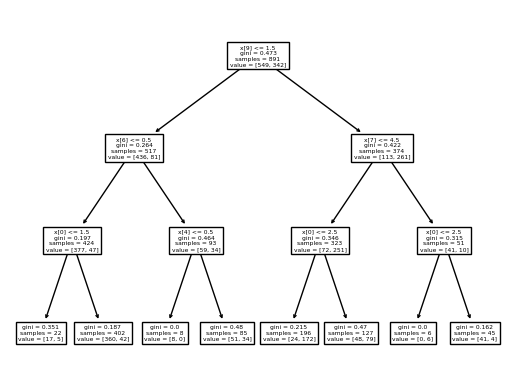

In [ ]:
tree.plot_tree(decision_tree)

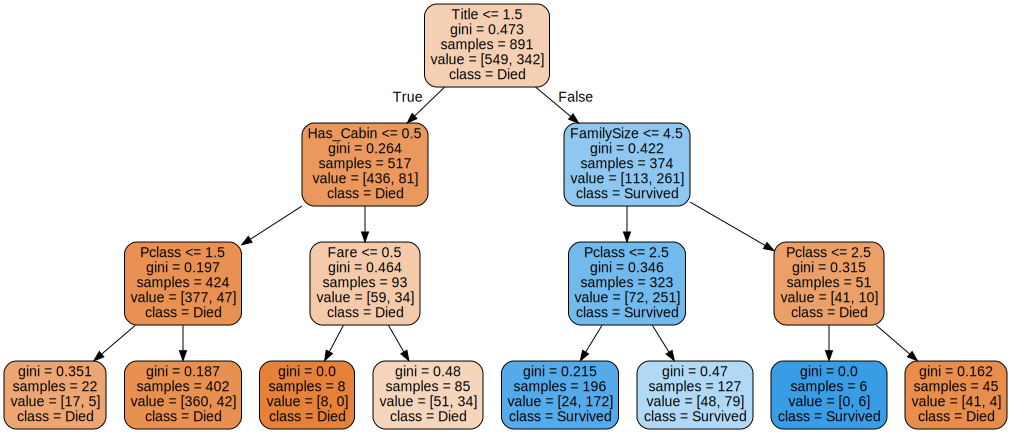

In [ ]:
dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

dot_data = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38

Точность дерева решений 82,38% по всему набору обучающих данных.

Немного про график:



*   Первая строка каждого узла (кроме последней строки) показывает условие разделения в форме «признак <= значение».
*   Далее неопределенность Джини узла, уже объясненную в этой комбинации разбиений.
*  **Samples** — это просто количество наблюдений, содержащихся в узле.  
* Value показывает распределение образцов по классам *(количество не выживших, количество выживших)*.
* Наконец, **Class** соответствует преобладающему классу каждого узла, и именно так наша модель будет классифицировать наблюдение.
* Цвет также представляет Class, непрозрачность увеличивается по мере фактического распределения образцов.


Таким образом, итог модели:

* Если наше наблюдение включает в себя статус **Mr**, то мы классифицируем его как погибший (все ветви в левой части дерева ведут к оранжевому узлу)
* Если оно не включает статус **Mr**, а **FamilySize** равен 4 или меньше, то мы классифицируем его как выживший.
* Если оно не включает титул **Mr**, **FamilySize** больше 4, а **Pclass** равен 2 или меньше, то мы классифицируем его как выживший.
* Если оно не включает в себя титул **Mr**, **FamilySize** больше 4 и **Pclass** больше 2, то мы классифицируем его как погибший.

## Задание (10 баллов)
Построить дерево решений для датасета iris.

5 баллов - построение дерева и оценка точности.
5 баллов - визуализация дерева.

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import model_selection
from sklearn import tree
import graphviz

iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)
df['target'] = iris.target
df['flower_species'] = df.target.apply(lambda x : iris.target_names[x])
print('Unique target values=', df['target'].unique())

df.sample(5)

Unique target values= [0 1 2]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,flower_species
7,5.0,3.4,1.5,0.2,0,setosa
116,6.5,3.0,5.5,1.8,2,virginica
50,7.0,3.2,4.7,1.4,1,versicolor
73,6.1,2.8,4.7,1.2,1,versicolor
103,6.3,2.9,5.6,1.8,2,virginica


In [ ]:
x = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df[['target']]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size= 0.2, random_state= 1)

In [ ]:
cls = tree.DecisionTreeClassifier(random_state= 1)
cls.fit(x_train ,y_train)

cls.score(x_test, y_test)

DecisionTreeClassifier(random_state=1)

In [ ]:
tree.plot_tree(cls)

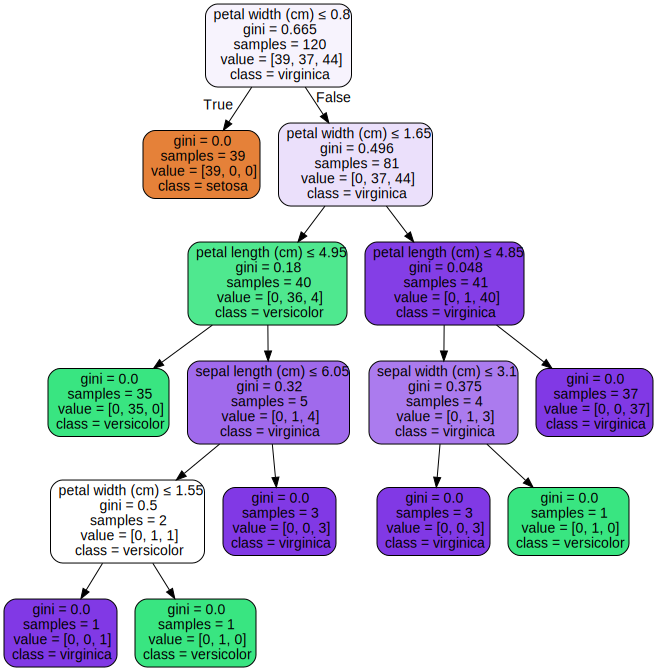

In [ ]:
dot_data = tree.export_graphviz(cls, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris_decision_tree")

dot_data = tree.export_graphviz(cls,
                                out_file=None,
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Random Forest

Основными недостатками деревьев решений являются их склонность к чрезмерному подбору, неспособность уловить взаимосвязи между функциями и использование жадных алгоритмов обучения (не гарантируется нахождение глобальной оптимальной модели). Их использование в Random Forest помогает смягчить некоторые из этих проблем.

Пример ансамбля: наблюдение, известное как Мудрость толпы. В 1906 году Фрэнсис Гальтон посетил загородную ярмарку в Плимуте, где он увидел конкурс для фермеров. 800 участников попытались оценить вес убитого быка. Реальный вес быка составлял 1198 фунтов. Хотя ни один из фермеров не мог угадать точный вес животного, средний показатель их прогнозов составил 1197 фунтов.

Аналогичная идея по снижению ошибок была принята в области машинного обучения.

## Бэггинг и бутстрэп

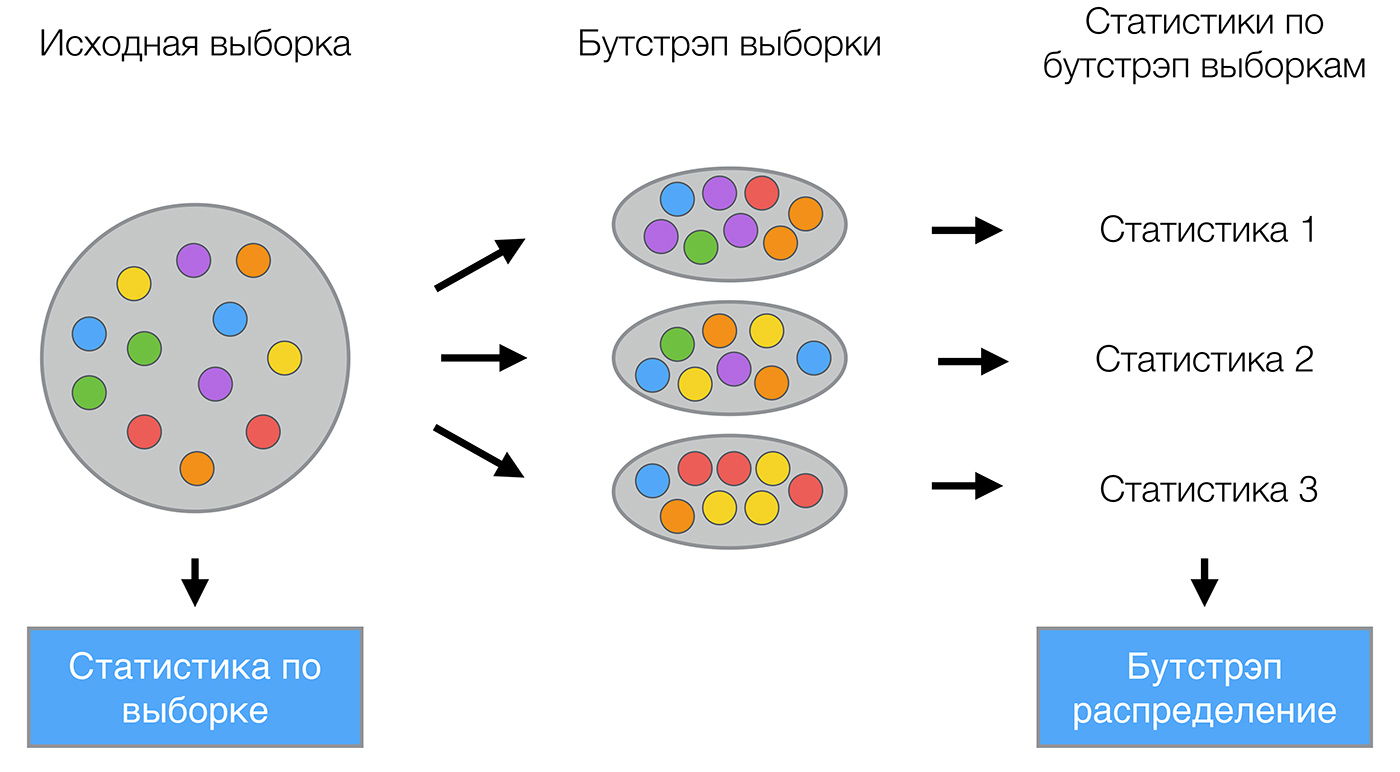

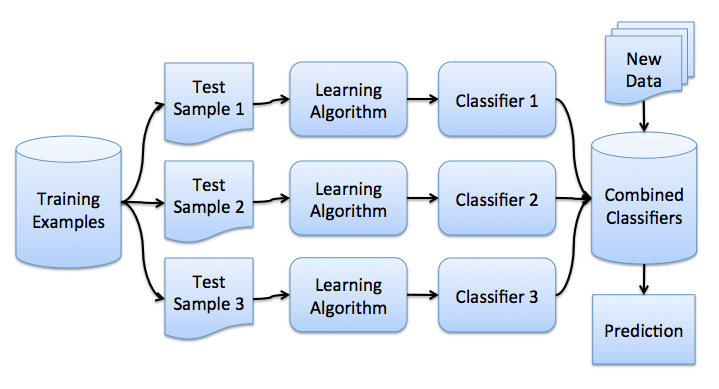

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Случайный лес, MSE = 14.07')

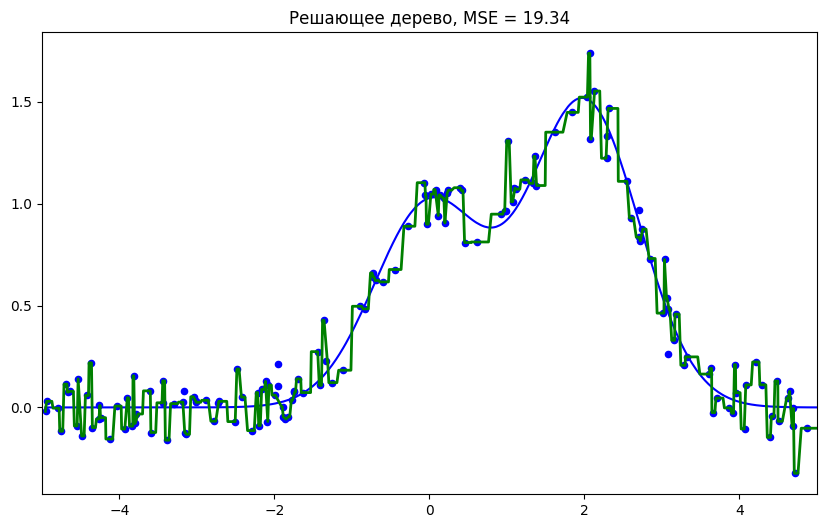

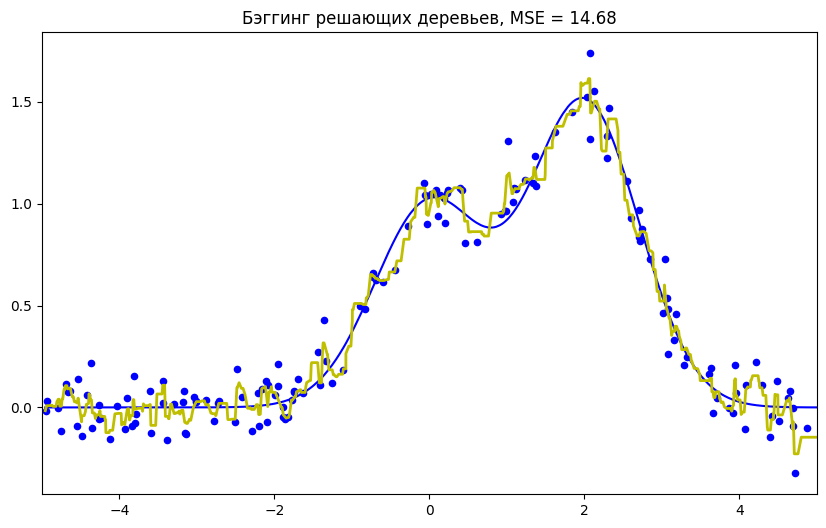

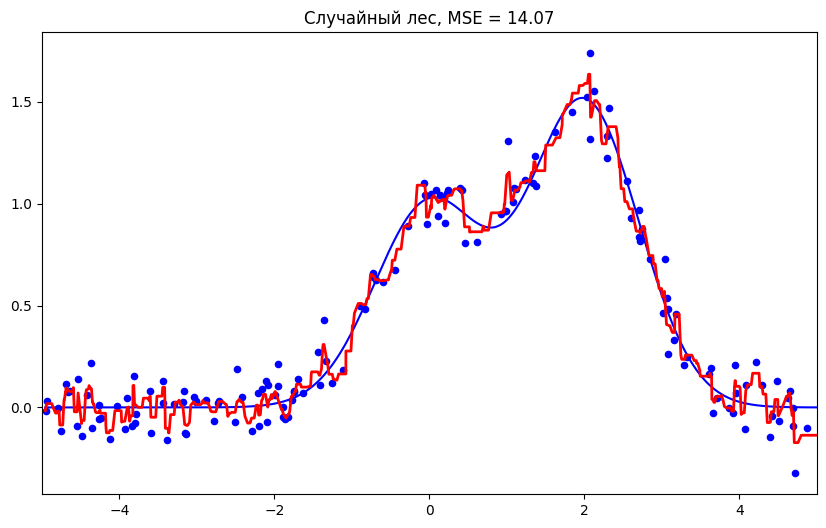

In [ ]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
%pylab inline
np.random.seed(42)
figsize(8, 6)
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

n_train = 150
n_test = 1000
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Решающее дерево, MSE = %.2f"
          % np.sum((y_test - d_predict) ** 2))

# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Бэггинг решающих деревьев, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))

Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:

* **n_estimators** — число деревьев в "лесу".
* **criterion**— функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse", так же можно выбрать "mae").
* **max_features** — число признаков, по которым ищется разбиение.
* **min_samples_leaf** — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1).
* **max_depth** — максимальная глубина дерева.

## Задание (5 баллов)

Построить случайный лес для набора данных Титаник.

Обязательное условие: улучшить точность модели, используя параметры леса.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier().fit(x_train, y_train)
predict = model.predict(x_test)

In [ ]:
print("Efficiency is :")
print(accuracy_score(ans['Survived'], predict)*100)

Efficiency is :
82.53588516746412
